# Apply ARIMA to school specific enrollments 

In [73]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
import plotly.express as px
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

In [74]:
# load data
school_enrollments = pd.read_csv('eda/data/enrollment_per_school.csv', encoding='latin-1')
school_enrollments

,EDUC DISTRICT,SCHOOL NAME,CONTROL,TYPE,QUINTILE,FEE_STATUS,2010,2011,2012,2013,...,Crowd14,Crowd15,Crowd16,Crowd17,Crowd18,Crowd19,Crowd20,Crowd21,Crowd22,Crowd23
0,METRO EAST,SOMERSET COLLEGE,INDEPENDENT,Combined School,NQ5,Fee charging,NaN,959.0,1043.0,1089.0,...,11,11,11,11,11,11,11,11,12,12
1,METRO EAST,BOSTON PRIVATE SCHOOL,INDEPENDENT,Combined School,NQ5,Fee charging,326.0,352.0,402.0,419.0,...,16,17,19,19,19,19,17,16,15,15
2,METRO EAST,CHUMISA PRIMARY SCHOOL,PUBLIC,Primary School,NQ2,No Fee,1145.0,1070.0,1127.0,1005.0,...,36,40,41,43,45,46,47,45,43,43
3,METRO EAST,CURRO SOMERSET WEST,INDEPENDENT,Combined School,NQ2,Fee charging,NaN,NaN,NaN,NaN,...,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,9,11,12
4,METRO EAST,EKUKHANYISELWENI CHRISTIAN SCHOOL,INDEPENDENT,Intermediate School,NQ2,No Fee,NaN,NaN,NaN,NaN,...,#VALUE!,#VALUE!,#VALUE!,14,35,33,36,34,34,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,METRO EAST,DE HOOP LAERSKOOL,PUBLIC,Primary School,NQ5,Fee charging,1113.0,1168.0,1207.0,1205.0,...,30,30,29,30,30,30,30,31,31,31
186,METRO EAST,DR. G.J. JOUBERT PRIMÊRE SKOOL,PUBLIC,Primary School,NQ4,No Fee,1222.0,1210.0,1192.0,1217.0,...,31,31,34,33,33,33,32,33,32,33
187,METRO EAST,EDUSMART ACADEMY,INDEPENDENT,Primary School,.,Fee charging,NaN,NaN,NaN,NaN,...,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,#VALUE!,7,7,7
188,METRO EAST,HOOFWEG PRIMARY SCHOOL,PUBLIC,Primary School,NQ3,No Fee,1219.0,1278.0,1233.0,1252.0,...,37,37,36,39,38,39,40,40,39,38


In [75]:
# select schools
school_subset = school_enrollments.copy()
school_subset.set_index('SCHOOL NAME', inplace=True)

# school_enrollments
schools = ['MASIYILE SENIOR SECONDARY SCHOOL', 'CENTRE OF SCIENCE AND TECHNOLOGY', 'INJONGO PRIMARY SCHOOL', 'HOPOLANG PRIMARY SCHOOL']
school_subset = school_subset.loc[schools].reset_index()
school_subset.replace(np.nan, 0, inplace=True)
school_subset


,SCHOOL NAME,EDUC DISTRICT,CONTROL,TYPE,QUINTILE,FEE_STATUS,2010,2011,2012,2013,...,Crowd14,Crowd15,Crowd16,Crowd17,Crowd18,Crowd19,Crowd20,Crowd21,Crowd22,Crowd23
0,MASIYILE SENIOR SECONDARY SCHOOL,METRO EAST,PUBLIC,Secondary School,NQ3,No Fee,1192.0,1243.0,1230.0,1246.0,...,32,34,33,33,35,36,36,36,36,40
1,CENTRE OF SCIENCE AND TECHNOLOGY,METRO EAST,PUBLIC,Secondary School,NQ3,No Fee,0.0,0.0,0.0,0.0,...,27,27,26,27,26,27,28,30,31,37
2,INJONGO PRIMARY SCHOOL,METRO EAST,PUBLIC,Primary School,NQ3,No Fee,1051.0,1019.0,951.0,1012.0,...,29,29,29,32,32,33,35,35,35,38
3,HOPOLANG PRIMARY SCHOOL,METRO EAST,PUBLIC,Intermediate School,NQ3,No Fee,718.0,724.0,760.0,719.0,...,34,33,38,38,40,39,38,38,38,39


In [76]:
# transform data to long format
school_subset = school_subset.reset_index()
long_school_subset = pd.melt(school_subset, id_vars='SCHOOL NAME', value_vars=['2010', '2011', '2012',
                                                                               '2013', '2014', '2015',
                                                                               '2016', '2017', '2018',
                                                                               '2019', '2020', '2021',
                                                                               '2022', '2023'])
long_school_subset


,SCHOOL NAME,variable,value
0,MASIYILE SENIOR SECONDARY SCHOOL,2010,1192.0
1,CENTRE OF SCIENCE AND TECHNOLOGY,2010,0.0
2,INJONGO PRIMARY SCHOOL,2010,1051.0
3,HOPOLANG PRIMARY SCHOOL,2010,718.0
4,MASIYILE SENIOR SECONDARY SCHOOL,2011,1243.0
5,CENTRE OF SCIENCE AND TECHNOLOGY,2011,0.0
6,INJONGO PRIMARY SCHOOL,2011,1019.0
7,HOPOLANG PRIMARY SCHOOL,2011,724.0
8,MASIYILE SENIOR SECONDARY SCHOOL,2012,1230.0
9,CENTRE OF SCIENCE AND TECHNOLOGY,2012,0.0


In [77]:
# plot enrollment over time
fig = px.line(long_school_subset, x='variable', y='value', color='SCHOOL NAME',
    labels={
        'value': 'student enrollment',
        'variable': 'Year',
        'SCHOOL NAME': 'School Name'
    },
title = 'Enrollment Time Series')
fig.show()

In [86]:
# method to select a school from the dataset
school_name = 'MASIYILE SENIOR SECONDARY SCHOOL'
def filter_schools(df, school_name):
    df_subset = df[df['SCHOOL NAME'] == school_name]

    long_subset = pd.melt(df_subset, id_vars='SCHOOL NAME', value_vars=['2010', '2011', '2012',
                                                                        '2013', '2014', '2015',
                                                                        '2016', '2017', '2018',
                                                                        '2019', '2020', '2021',
                                                                        '2022', '2023'])
    
    long_subset.rename(columns={'variable': 'YEAR', 'value': 'TOTAL 1'}, inplace=True)
    return long_subset

a_school = filter_schools(school_enrollments, school_name)

# remove nan years
# a_school = a_school.iloc[4:]
a_school

,SCHOOL NAME,YEAR,TOTAL 1
0,MASIYILE SENIOR SECONDARY SCHOOL,2010,1192.0
1,MASIYILE SENIOR SECONDARY SCHOOL,2011,1243.0
2,MASIYILE SENIOR SECONDARY SCHOOL,2012,1230.0
3,MASIYILE SENIOR SECONDARY SCHOOL,2013,1246.0
4,MASIYILE SENIOR SECONDARY SCHOOL,2014,1139.0
5,MASIYILE SENIOR SECONDARY SCHOOL,2015,1213.0
6,MASIYILE SENIOR SECONDARY SCHOOL,2016,1203.0
7,MASIYILE SENIOR SECONDARY SCHOOL,2017,1191.0
8,MASIYILE SENIOR SECONDARY SCHOOL,2018,1250.0
9,MASIYILE SENIOR SECONDARY SCHOOL,2019,1283.0


In [87]:
# helper method to make data stationary
def subtract_from_previous(arr):
    if len(arr) == 0:
        return []

    return [arr[i] - arr[i - 1] for i in range(1, len(arr))]

[0.9283401903062468, 0.000825597317472495]

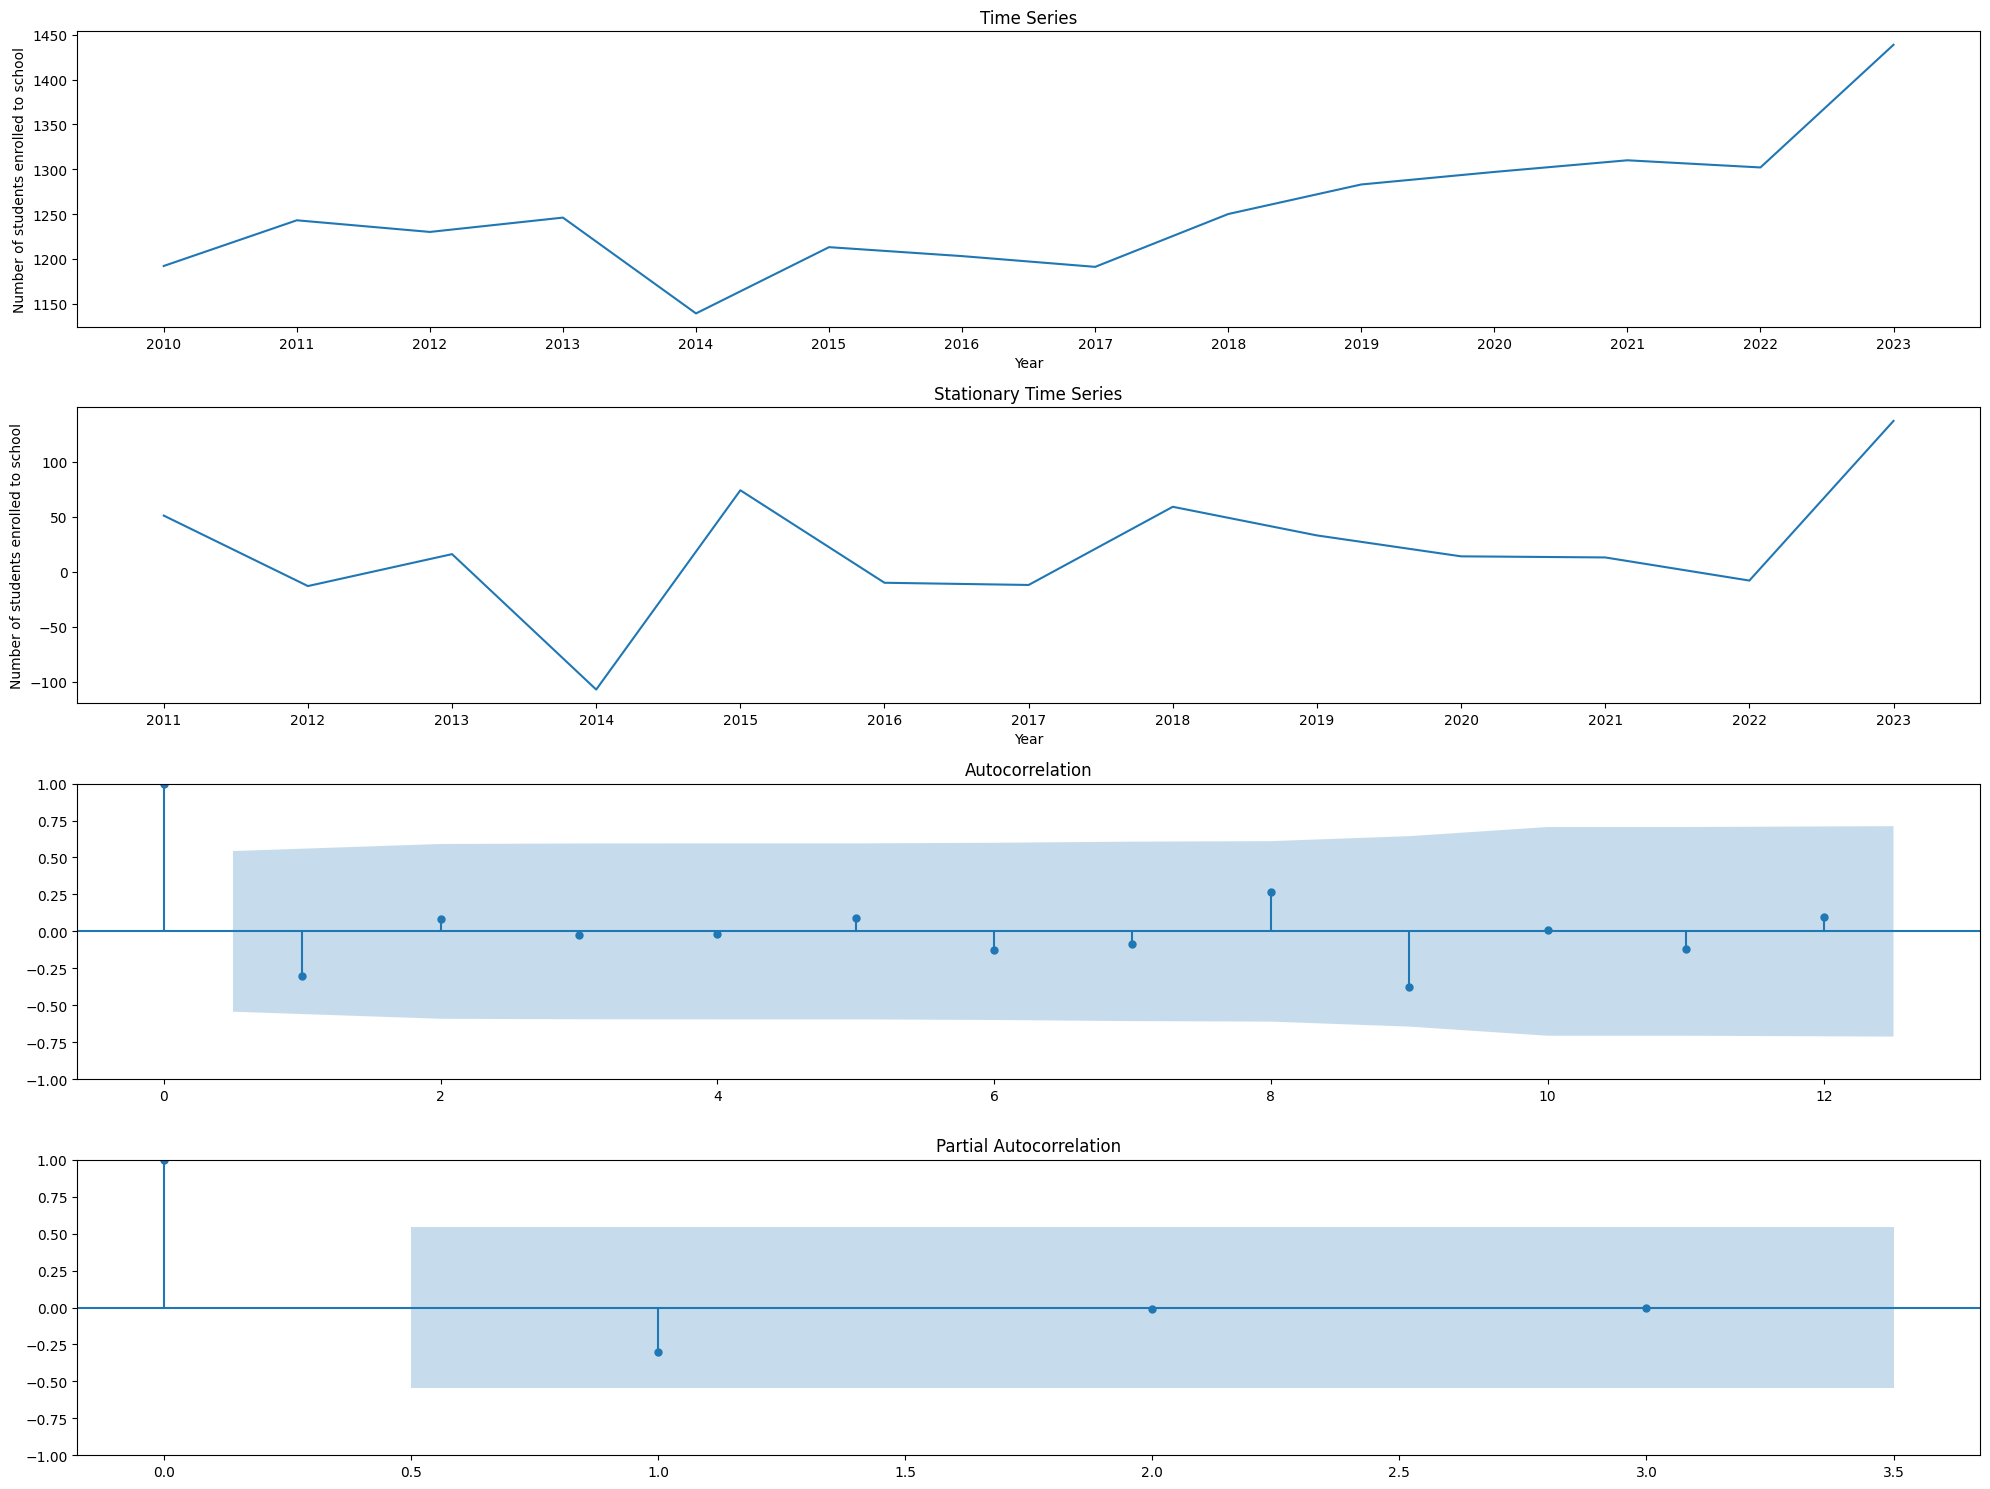

In [88]:
# fit plot over time with stationarity pacf and acf
# This function plots time series of student enrollment for a given metro, circuit and grade
# If the time series is not stationary it is converted so that it is stationary and the stationary plot will be plotted
# the pacf and acf plots are also plotted
fig, axes = plt.subplots(4, 1, figsize=(20,15))

# def plot_learner_ts(metro, circuit, count_var):
def plot_learner_ts(df_subset):

    # extract the counts
    count_var = df_subset.iloc[:,[2]].columns.values[0]
    
    # plot the stationary time series if time series is not stationary
    adf_val = adfuller(df_subset[str(count_var)])
    
    # if p val > 0.05 then time series is not stationary. If p value < 0.05 then it is stationary
    # if time series is stationary then convert to stationary plot
    if adf_val[1] > 0.05:
        # plot number of students over time
        axes[0].plot(df_subset['YEAR'], (df_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # convert time series to stationary time series
        transformed_ts = subtract_from_previous(np.array(df_subset[str(count_var)]))
        transformed_adf = adfuller(transformed_ts)

        axes[1].plot(df_subset['YEAR'][1:], transformed_ts) # time series for stationary plot
        axes[1].set_title('Stationary Time Series')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(np.array(transformed_ts), ax=axes[2]) # acf for stationary plot

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(transformed_ts, lags=3, ax=axes[3]) # pacf for stationary plot
    
    # if the time series is already stationary then plot the time series, acf and pacf plots as is
    else:
        # plot number of students over time
        axes[0].plot(df_subset['YEAR'], (df_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(df_subset[str(count_var)], ax=axes[2])

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(df_subset[str(count_var)], lags=2, ax=axes[3])

    # plot all graphs on same grid
    plt.tight_layout()

    # return transformed adf only if the transformation needed to happen
    if adf_val[1] > 0.05:
        return [adf_val[1], transformed_adf[1]]
    else:
        return adf_val[1]

plot_learner_ts(a_school)

In [96]:
# apply arima with rolling forecasts
# Using rolling predictions

X = a_school['TOTAL 1'].values

# split into train and test sets
size = int(len(X) * 0.4)
train, test = X[0:size], X[size:len(X)]
print(len(test))
history = [x for x in train]
predictions = list()
observations = list()
preds_for_rmse = list()

num_pred_years = 10

# rolling forecast
for t in range(len(test) + num_pred_years):
 model = ARIMA(history, order=(1,2,1)) # run the arima model on train data
 model_fit = model.fit() # fit the model
 output = model_fit.forecast() # forecast next value
 yhat = output[0]
 predictions.append(yhat)

#  obs = test[t]
#  history.append(obs)
#  print('predicted=%f, expected=%f' % (yhat, obs))
 
 if t < len(test):
    preds_for_rmse.append(yhat)
    obs = test[t]
    observations.append(obs)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
 
 # forecast predictions (2023 to 2028)
 else:
   history.append(yhat)
   observations.append(np.nan)
   print('predicted=%f' % (yhat))

rmse = sqrt(mean_squared_error(test, preds_for_rmse))
print('Test RMSE: %.3f' % rmse)

# save actual values and forecasted values to a csv
# min_year = int(min(a_school['YEAR']))
min_year = a_school['YEAR'][len(test):len(test)+1].values[0]
max_year = 2023 + 1
years = np.arange(int(min_year),int(max_year) + num_pred_years)

data = {'observations': observations, 'predictions': predictions, 'year': years}
print(data)
preds_df = pd.DataFrame(data)
preds_df.to_csv('output/school_predictions/'+school_name+'_predictions.csv', index=False)

9
predicted=1092.329801, expected=1213.000000
predicted=1133.293041, expected=1203.000000
predicted=748.013750, expected=1191.000000
predicted=1193.996047, expected=1250.000000
predicted=1226.156250, expected=1283.000000


c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

c:\Users\GEdwards\Python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\GEdwards\Python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1282.962086, expected=1297.000000
predicted=1305.027505, expected=1310.000000
predicted=1318.748905, expected=1302.000000
predicted=1316.768076, expected=1439.000000
predicted=1420.781293
predicted=1474.597491
predicted=1494.158984
predicted=1529.673475
predicted=1557.446370
predicted=1588.793015
predicted=1618.345912
predicted=1648.698662
predicted=1678.621122
predicted=1708.717530
Test RMSE: 162.436
{'observations': [1213.0, 1203.0, 1191.0, 1250.0, 1283.0, 1297.0, 1310.0, 1302.0, 1439.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'predictions': [1092.3298012783, 1133.293041290522, 748.0137500362368, 1193.9960466336374, 1226.1562498390163, 1282.9620864518442, 1305.0275051308279, 1318.7489045241218, 1316.7680759728714, 1420.7812928281705, 1474.5974907820216, 1494.158983543641, 1529.67347489937, 1557.4463699099474, 1588.7930147596285, 1618.3459122891995, 1648.6986615103792, 1678.6211223273936, 1708.7175299233218], 'year': array([2019, 2020, 2021, 2022, 2023, 2024, 2025

ValueError: All arrays must be of the same length

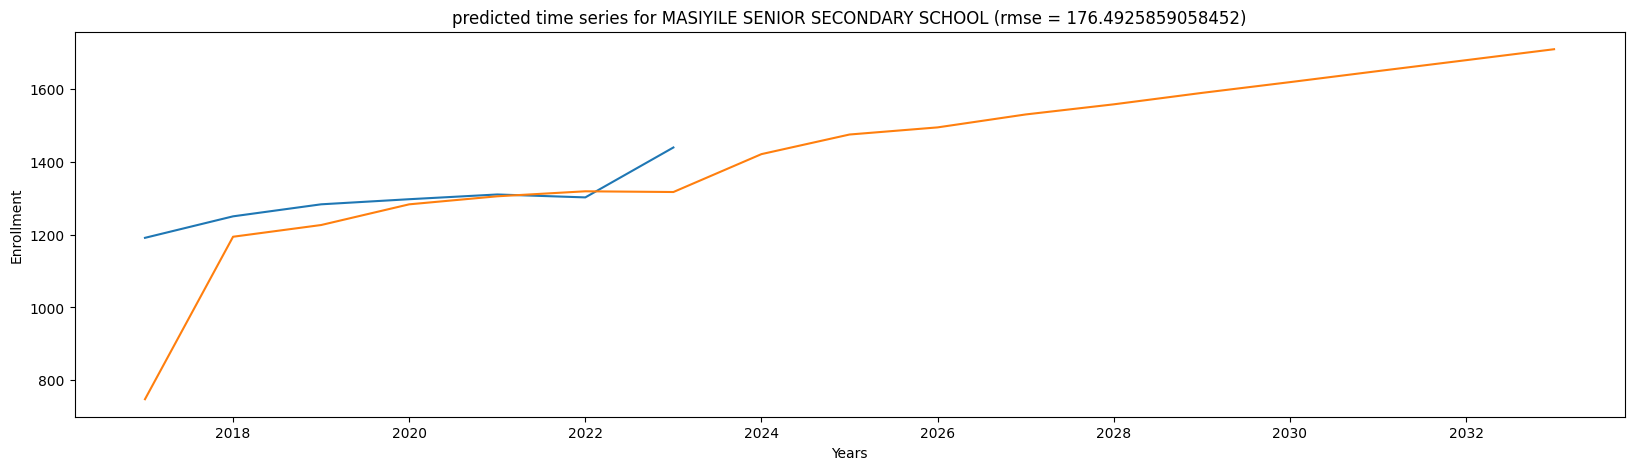

In [90]:
# plot forecasts against actual outcomes
fig, axes = plt.subplots(1, 1, figsize=(20,5))

# plt.plot(test)
# plt.plot(predictions, color='red')

plt.plot(preds_df['year'], preds_df['observations'])
plt.plot(preds_df['year'], preds_df['predictions'])

plt.title('predicted time series for '+ school_name + ' (rmse = '+str(rmse)+')')
plt.xlabel('Years')
plt.ylabel('Enrollment')
plt.show()